# Analyze data retrieved from Wayback Machine

In [1]:
# Import main packages
import pandas as pd
import os
import gc

from urllib.parse import urlparse
from datetime import datetime
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import json
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import itertools

# Define directories
def find_directory_upwards(dir_name):
    """
    Find the absolute path to a directory with the given name by searching upwards
    from the current notebook's directory.

    Parameters:
    dir_name (str): The name of the directory to find.

    Returns:
    str: The absolute path to the directory if found, otherwise None.
    """
    # Get the current notebook's directory
    current_dir = os.getcwd()
    
    while True:
        # Check if the directory exists in the current directory
        potential_path = os.path.join(current_dir, dir_name)
        if os.path.isdir(potential_path):
            return potential_path
        
        # Move to the parent directory
        parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
        
        # If the current directory is the root directory, stop searching
        if current_dir == parent_dir:
            break
        
        current_dir = parent_dir
    
    # If the directory is not found, return None
    return None

code_dir = find_directory_upwards('codes')
raw_data_dir = find_directory_upwards('raw_data')
int_data_dir = find_directory_upwards('int_data')
final_data_dir = find_directory_upwards('final_data')
output_dir = find_directory_upwards('output')

print(code_dir)
# print(raw_data_dir)
print(int_data_dir)
print(output_dir)

/home/sosajuanbautista/aeai-filestore/projects/agentic/codes
/home/sosajuanbautista/aeai-filestore/projects/agentic/int_data
/home/sosajuanbautista/aeai-filestore/projects/agentic/output


## Load data

In [2]:
# Load JSON with full urls
path = os.path.join(final_data_dir, 'commodity_price_sources', 'wayback_machine', 'archive_dates_fullurls_2024-11-05_11.33.json')
with open(path) as json_file:
    fullurls = json.load(json_file)

# Save the length
fullurls_len = len(fullurls)
print(fullurls_len)

161


In [3]:
# Load JSON with base urls
path = os.path.join(final_data_dir, 'commodity_price_sources', 'wayback_machine', f'archive_dates_baseurls_2024-11-05_11.40.json')
with open(path) as json_file:
    baseurls = json.load(json_file)

# Save the length
baseurls_len = len(baseurls)
print(baseurls_len)

75


In [4]:
# Load URLs for top 20 commodity categories
path = os.path.join(final_data_dir, 'commodity_price_sources', 'df_top20_commodity_prices_search_results_evaluated.csv')
df_commodities = pd.read_csv(path)

# Rename url to full_url
df_commodities.rename(columns={'url': 'full_url'}, inplace=True)

# Add column base_url
df_commodities['base_url'] = df_commodities['full_url'].apply(lambda x: urlparse(x).netloc)

print(df_commodities.columns.values)
print(df_commodities.shape)

df_commodities.head()

['commodity' 'search_term' 'title' 'full_url' 'justification'
 'raw_content' 'base_url']
(161, 7)


,commodity,search_term,title,full_url,justification,raw_content,base_url
0,Rotary tiller or power tiller,Rotary tiller or power tiller blue book,Tarter Farm & Ranch 4 ft. Light-Duty Rotary Ti...,https://www.tractorsupply.com/tsc/product/farm...,The search result provides a specific product ...,Error\n \nSign In / Enroll\nGet rewarded!\nTar...,www.tractorsupply.com
1,Rotary tiller or power tiller,Rotary tiller or power tiller used prices,Rotary Tillers For Sale | MyLittleSalesman.com,https://www.mylittlesalesman.com/rotary-tiller...,The webpage provides a list of rotary tillers ...,Rotary Tillers For Sale | MyLittleSalesman.com...,www.mylittlesalesman.com
2,Rotary tiller or power tiller,Rotary tiller or power tiller price list,Tillers - Rototillers & Cultivators - The Home...,https://www.homedepot.com/b/Outdoors-Outdoor-P...,The webpage provides a list of various tiller ...,Select store\n...\n...\nCart\nSelect store\n.....,www.homedepot.com
3,Rotary tiller or power tiller,Power tiller price listings,Rotary Tillage Equipment For Sale in OKLAHOMA,https://www.tractorhouse.com/listings/rotary-t...,The search result provides a listing of rotary...,NaN,www.tractorhouse.com
4,Rotary tiller or power tiller,Power tiller price listings,Rotary Tillage Equipment For Sale | TractorHou...,https://www.tractorhouse.com/listings/for-sale...,The webpage provides a listing of rotary tilla...,NaN,www.tractorhouse.com


## Prepare data

In [5]:
# Diagnose for how many we have data

print("Count of full URLS", len(fullurls))

fullurls_with_data = {k: v for k, v in fullurls.items() if isinstance(v, list)}
fullurls_request_exception = {k: v for k, v in fullurls.items() if v=='REQUEST_EXCEPTION'}
fullurls_no_data = {k: v for k, v in fullurls.items() if v=='NO_DATA'}
fullurls_with_status_code_error = {k: v for k, v in fullurls.items() if v=='STATUS_CODE_ERROR'}

print("Count of full URLS with data", len(fullurls_with_data))
print("Count of full URLS with request exception", len(fullurls_request_exception))
print("Count of full URLS with no data", len(fullurls_no_data))
print("Count of full URLS with status code error", len(fullurls_with_status_code_error))

print('\n')

print("Count of base URLS", len(baseurls))

baseurls_with_data = {k: v for k, v in baseurls.items() if isinstance(v, list)}
baseurls_request_exception = {k: v for k, v in baseurls.items() if v=='REQUEST_EXCEPTION'}
baseurls_no_data = {k: v for k, v in baseurls.items() if v=='NO_DATA'}
baseurls_with_status_code_error = {k: v for k, v in baseurls.items() if v=='STATUS_CODE_ERROR'}

print("Count of base URLS with data", len(baseurls_with_data))
print("Count of base URLS with request exception", len(baseurls_request_exception))
print("Count of base URLS with no data", len(baseurls_no_data))
print("Count of base URLS with status code error", len(baseurls_with_status_code_error))

Count of full URLS 161
Count of full URLS with data 45
Count of full URLS with request exception 95
Count of full URLS with no data 21
Count of full URLS with status code error 0


Count of base URLS 75
Count of base URLS with data 35
Count of base URLS with request exception 40
Count of base URLS with no data 0
Count of base URLS with status code error 0


In [6]:
# Create a df from the dictionaries

# Full urls
df_fullurls = []
for key, value in fullurls.items():

    if not (value == 'REQUEST_EXCEPTION' or value == 'NO_DATA' or value == 'STATUS_CODE_ERROR'):
        for date in value:
            date = datetime.strptime(date, '%Y%m%d%H%M%S')
            # Convert to DAY format
            date = date.strftime('%Y-%m-%d')
            df_fullurls.append({'url': key, 'timestamp': date})
df_fullurls = pd.DataFrame(df_fullurls)
# remove duplicates
df_fullurls = df_fullurls.drop_duplicates()
print(df_fullurls.shape)
# Add url_type
df_fullurls['url_type'] = 'full_url'
df_fullurls['timestamp'] = pd.to_datetime(df_fullurls['timestamp'])

# Base urls
df_baseurls = []
for key, value in baseurls.items():

    if not (value == 'REQUEST_EXCEPTION' or value == 'NO_DATA' or value == 'STATUS_CODE_ERROR'):
        for date in value:
            date = datetime.strptime(date, '%Y%m%d%H%M%S')
            # Convert to DAY format
            date = date.strftime('%Y-%m-%d')
            df_baseurls.append({'url': key, 'timestamp': date})
df_baseurls = pd.DataFrame(df_baseurls)
# remove duplicates
df_baseurls = df_baseurls.drop_duplicates()
print(df_baseurls.shape)
# Add url_type
df_baseurls['url_type'] = 'base_url'
df_baseurls['timestamp'] = pd.to_datetime(df_baseurls['timestamp'])

# Concatenate
df_urls = pd.concat([df_fullurls, df_baseurls], axis=0)
print(df_urls.shape)

df_urls.head()

(11753, 2)
(56503, 2)
(68256, 3)


,url,timestamp,url_type
0,https://www.newegg.com/Desktop-Computer/Catego...,2024-09-26,full_url
1,https://www.newegg.com/Desktop-Computer/Catego...,2024-09-27,full_url
2,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-01,full_url
3,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-02,full_url
4,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-03,full_url


In [7]:
# Create a df with start and end dates
df_start_end_dates = df_urls.groupby('url').agg({'timestamp': ['min', 'max']}).reset_index()
df_start_end_dates.columns = ['url', 'earliest_date', 'latest_date']
print(df_start_end_dates.shape)
df_start_end_dates.head()


(80, 3)


,url,earliest_date,latest_date
0,apollotools.com,2003-09-04,2024-10-02
1,approvedcosts.com,2021-03-24,2024-06-19
2,buildingelements.com,2011-04-09,2024-10-06
3,commercialcopymachine.com,2011-02-07,2024-09-20
4,gabionsupply.com,2012-08-03,2024-09-25


In [8]:
# Merge df_urls with df_commodities
df_urls_m = pd.merge(df_urls, df_commodities[['full_url', 'commodity']], left_on='url', right_on='full_url', how='left')
df_urls_m = pd.merge(df_urls_m, df_commodities[['base_url', 'commodity']], left_on='url', right_on='base_url', how='left')

# Make commodity_x and commodity_y one column
df_urls_m['commodity'] = df_urls_m['commodity_x'].fillna(df_urls_m['commodity_y'])
df_urls_m.drop(columns=['commodity_x', 'commodity_y', 'full_url', 'base_url'], inplace=True)

df_urls_m.head()

,url,timestamp,url_type,commodity
0,https://www.newegg.com/Desktop-Computer/Catego...,2024-09-26,full_url,Desktop computer
1,https://www.newegg.com/Desktop-Computer/Catego...,2024-09-27,full_url,Desktop computer
2,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-01,full_url,Desktop computer
3,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-02,full_url,Desktop computer
4,https://www.newegg.com/Desktop-Computer/Catego...,2024-10-03,full_url,Desktop computer


In [9]:
# Merge df_commodiies with df_start_end_dates
df_commodities_m = pd.merge(df_commodities, df_start_end_dates[['url', 'earliest_date', 'latest_date']], 
left_on='full_url', right_on='url', how='left')
df_commodities_m = pd.merge(df_commodities_m, df_start_end_dates[['url', 'earliest_date', 'latest_date']], 
left_on='base_url', right_on='url', how='left', suffixes=('', '_base_url'))

df_commodities_m.drop(columns=['url', 'url_base_url'], inplace=True)

# # Save the updated DataFrame
# path = os.path.join(final_data_dir, 'commodity_price_sources', 'df_top20_commodity_prices_search_results_evaluated_with_archive_dates.csv')
# df_commodities_m.to_csv(path, index=False)

df_commodities_m.head()

,commodity,search_term,title,full_url,justification,raw_content,base_url,earliest_date,latest_date,earliest_date_base_url,latest_date_base_url
0,Rotary tiller or power tiller,Rotary tiller or power tiller blue book,Tarter Farm & Ranch 4 ft. Light-Duty Rotary Ti...,https://www.tractorsupply.com/tsc/product/farm...,The search result provides a specific product ...,Error\n \nSign In / Enroll\nGet rewarded!\nTar...,www.tractorsupply.com,NaT,NaT,NaT,NaT
1,Rotary tiller or power tiller,Rotary tiller or power tiller used prices,Rotary Tillers For Sale | MyLittleSalesman.com,https://www.mylittlesalesman.com/rotary-tiller...,The webpage provides a list of rotary tillers ...,Rotary Tillers For Sale | MyLittleSalesman.com...,www.mylittlesalesman.com,NaT,NaT,NaT,NaT
2,Rotary tiller or power tiller,Rotary tiller or power tiller price list,Tillers - Rototillers & Cultivators - The Home...,https://www.homedepot.com/b/Outdoors-Outdoor-P...,The webpage provides a list of various tiller ...,Select store\n...\n...\nCart\nSelect store\n.....,www.homedepot.com,2020-10-06,2024-06-15,1996-11-05,2024-11-04
3,Rotary tiller or power tiller,Power tiller price listings,Rotary Tillage Equipment For Sale in OKLAHOMA,https://www.tractorhouse.com/listings/rotary-t...,The search result provides a listing of rotary...,NaN,www.tractorhouse.com,NaT,NaT,2005-02-07,2024-10-08
4,Rotary tiller or power tiller,Power tiller price listings,Rotary Tillage Equipment For Sale | TractorHou...,https://www.tractorhouse.com/listings/for-sale...,The webpage provides a listing of rotary tilla...,NaN,www.tractorhouse.com,NaT,NaT,2005-02-07,2024-10-08


## Make Plots

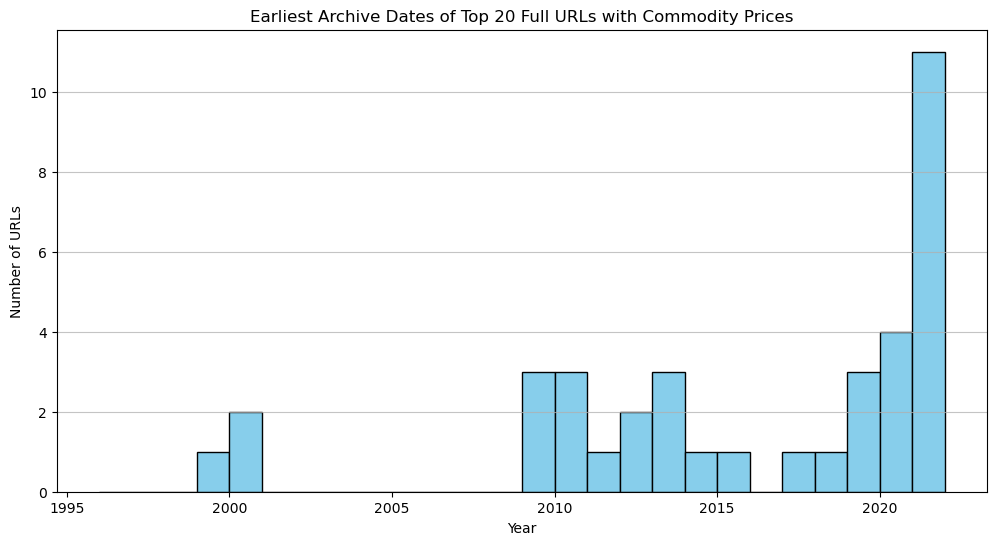

In [10]:
# Create a histogram with the years of the earliest archive dates
earliest_year = df_commodities_m['earliest_date'].dt.year

plt.figure(figsize=(12, 6))
plt.hist(earliest_year, bins=range(1996, 2023), color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of URLs')
plt.title('Earliest Archive Dates of Top 20 Full URLs with Commodity Prices')
plt.grid(axis='y', alpha=0.75)
plt.show()

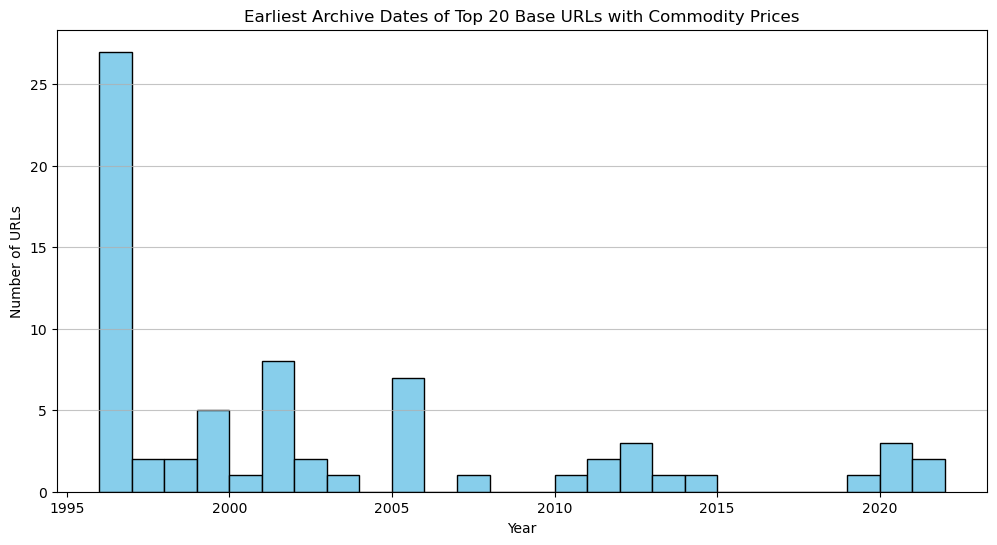

In [11]:
# Create a histogram with the years of the earliest archive dates
earliest_year = df_commodities_m['earliest_date_base_url'].dt.year

plt.figure(figsize=(12, 6))
plt.hist(earliest_year, bins=range(1996, 2023), color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of URLs')
plt.title('Earliest Archive Dates of Top 20 Base URLs with Commodity Prices')
plt.grid(axis='y', alpha=0.75)
plt.show()

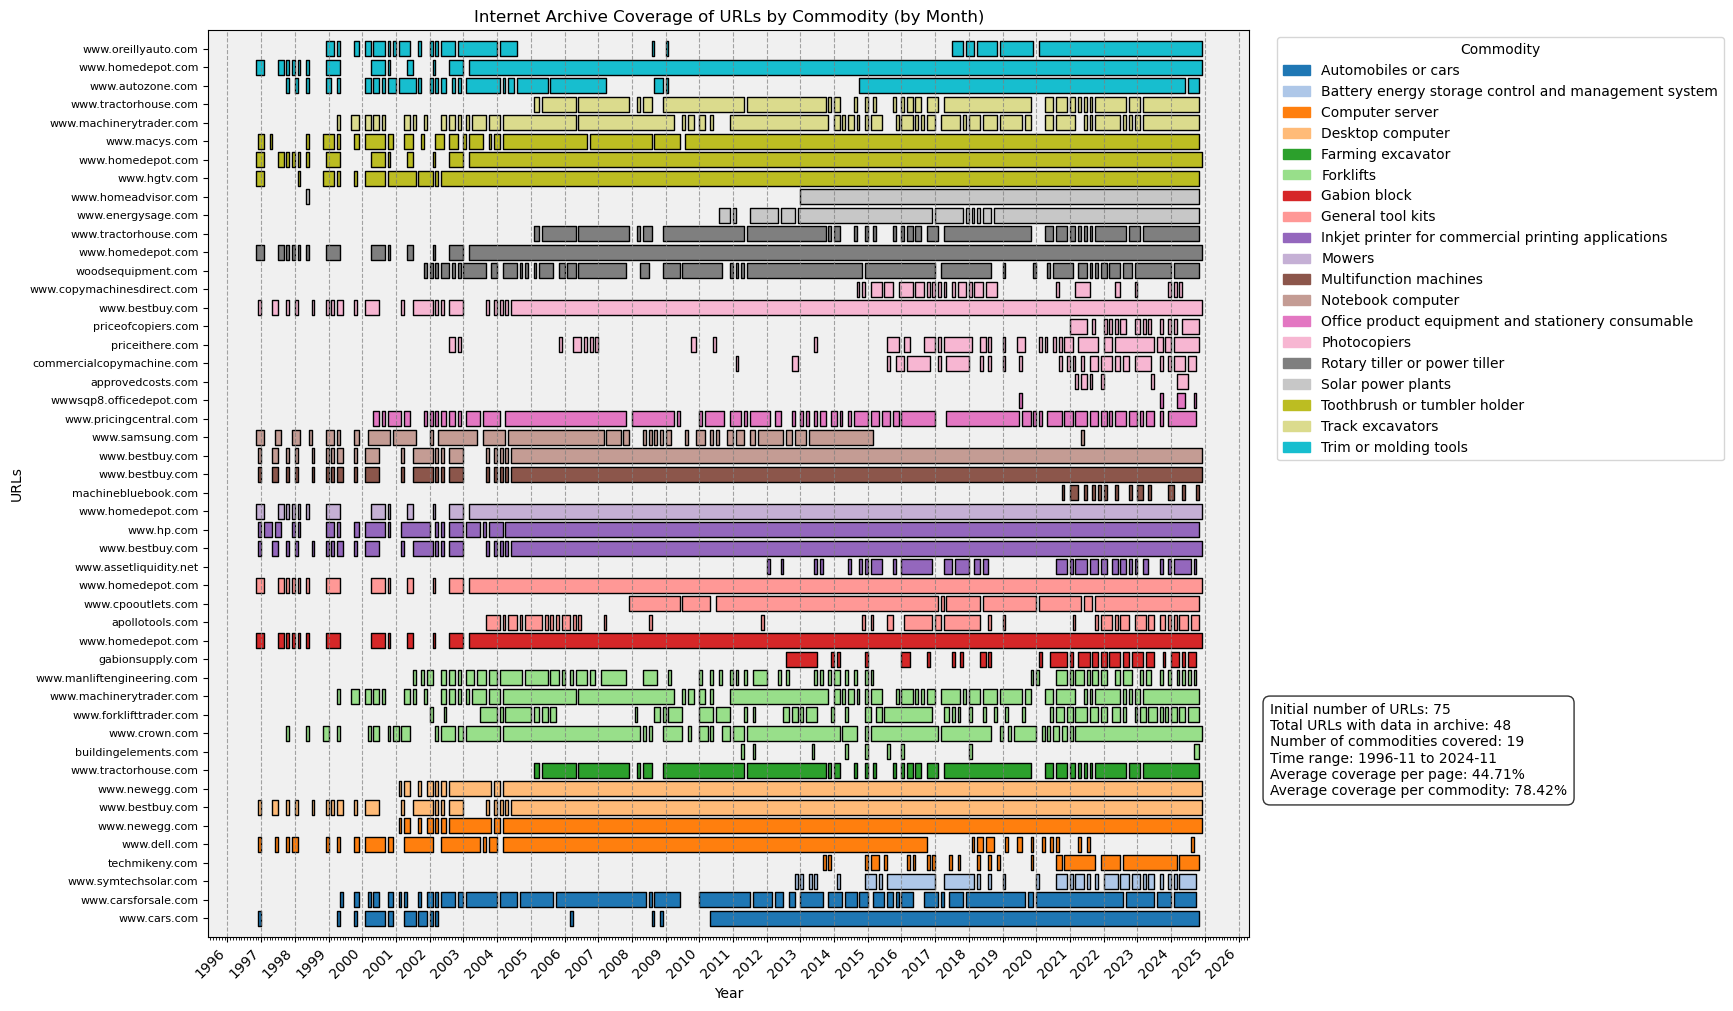

In [12]:
# -----------------------------
# 1. Data Preparation
# -----------------------------

# Filter for 'base_url' type
df_archive_dates_plot = df_urls_m[df_urls_m['url_type'] == 'base_url'].copy()

# Remove rows with invalid or missing timestamps, URLs, or commodities
df_archive_dates_plot = df_archive_dates_plot.dropna(subset=['timestamp', 'url', 'commodity'])

# Convert timestamp to month format (set day to first of the month)
df_archive_dates_plot['timestamp'] = df_archive_dates_plot['timestamp'].dt.to_period('M').dt.to_timestamp()

# Shorten the URL to make it more readable
df_archive_dates_plot['url'] = df_archive_dates_plot['url'].apply(
    lambda x: x[:45] + '...' if len(x) > 45 else x
)

# Drop duplicates to ensure unique (url, commodity, timestamp) combinations
df_archive_dates_plot = df_archive_dates_plot[['url', 'commodity', 'timestamp']].drop_duplicates()

# Create a unique list of URLs and their associated commodities
url_commodity = df_archive_dates_plot[['url', 'commodity']].drop_duplicates()

# Assign a unique index for Y-axis positions
url_commodity = url_commodity.sort_values(['commodity', 'url'])
url_commodity.reset_index(drop=True, inplace=True)
url_commodity['y_index'] = url_commodity.index

# Create mappings from URL to y_index and commodity
url_commodity_combo_to_y = dict(zip(url_commodity[['url', 'commodity']].apply(tuple, axis=1), url_commodity['y_index']))

# Create a colormap for commodities
commodities = url_commodity['commodity'].unique()
colors = plt.cm.tab20.colors  # Use a colormap with enough distinct colors
if len(commodities) > len(colors):
    # Extend the colormap if there are more commodities than colors
    color_cycle = itertools.cycle(colors)
    colors_extended = [next(color_cycle) for _ in range(len(commodities))]
    color_map = dict(zip(commodities, colors_extended))
else:
    color_map = dict(zip(commodities, colors[:len(commodities)]))

# Function to identify consecutive month ranges for a list of timestamps
def get_consecutive_ranges(timestamps):
    """
    Given a sorted list of timestamps (datetime objects),
    return a list of (start, duration_in_days) tuples representing consecutive ranges.
    """
    if not timestamps:
        return []
    
    # Sort the timestamps
    sorted_ts = sorted(timestamps)
    
    ranges = []
    start = sorted_ts[0]
    end = start
    
    for current in sorted_ts[1:]:
        # If current timestamp is exactly one month after the previous, extend the range
        expected_next = (end + pd.DateOffset(months=1)).replace(day=1)
        if current == expected_next:
            end = current
        else:
            # Calculate the duration in days for the broken_barh
            duration = (end + pd.DateOffset(months=1) - start).days
            ranges.append((start, duration))
            start = current
            end = current
    # Append the last range
    duration = (end + pd.DateOffset(months=1) - start).days
    ranges.append((start, duration))
    
    return ranges

# Create a dictionary to hold ranges per URL
url_ranges = {}

# Group the DataFrame by URL and collect ranges
for url_commodity_combo, group in df_archive_dates_plot.groupby(['url', 'commodity']): # Reverse the order for better visualization
    timestamps = group['timestamp'].tolist()
    ranges = get_consecutive_ranges(timestamps)
    url_ranges[url_commodity_combo] = ranges

# -----------------------------
# 2. Plotting
# -----------------------------

# Initialize the plot
num_urls = len(url_commodity)
fig_height = max(10, num_urls * 0.1)  # Adjust the multiplier as needed
fig, ax = plt.subplots(figsize=(15, fig_height))

# Set the background color to light grey
ax.set_facecolor('#f0f0f0')  # Adjust the hex color code for different shades of grey

# Plot each URL's data as broken bars
for url_commodity_combo, ranges in url_ranges.items():
    y = url_commodity_combo_to_y.get(url_commodity_combo)
    commodity = url_commodity_combo[1]
    color = color_map.get(commodity, 'gray')  # Default to gray if commodity not found
    
    for start, duration in ranges:
        # Convert start to matplotlib's date format
        start_num = mdates.date2num(start)
        # Duration in days; for broken_barh, width is in days
        width = duration
        ax.broken_barh(
            [(start_num, width)],
            (y - 0.4, 0.8),  # (y_position, height)
            facecolors=color,
            edgecolor='black'
        )

# -----------------------------
# 3. Customization
# -----------------------------

# Set Y-axis labels to the URLs
ax.set_yticks(url_commodity['y_index'])
ax.set_yticklabels(url_commodity['url'], fontsize=8)  # Adjust fontsize as needed

# Format X-axis to show years and months
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('URLs')
ax.set_title('Internet Archive Coverage of URLs by Commodity (by Month)')

# Improve layout to accommodate labels and legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make space for the legend

# Remove grid lines for a cleaner look
ax.grid(False)

# Rotate X-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Create custom legend
# To avoid duplicate labels in the legend, create a unique list of patches
unique_commodities = commodities
legend_handles = [
    mpatches.Patch(color=color_map[commodity], label=commodity)
    for commodity in unique_commodities
]

ax.legend(handles=legend_handles, title='Commodity', bbox_to_anchor=(1.02, 1), loc='upper left')

# Optional: Adjust Y-axis limits to add some padding
ax.set_ylim(-1, num_urls)

# Optional: Add gridlines at major ticks for X-axis
ax.xaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.7)

# -----------------------------
# 4. Adding the Summary Statistics Box
# -----------------------------

# Compute summary statistics
total_urls = len(url_commodity)
number_of_commodities = len(commodities)
earliest_date = df_archive_dates_plot['timestamp'].min().strftime('%Y-%m')
latest_date = df_archive_dates_plot['timestamp'].max().strftime('%Y-%m')

# Calculate the total number of months in the time range
all_months = pd.period_range(start=df_archive_dates_plot['timestamp'].min(), 
                             end=df_archive_dates_plot['timestamp'].max(), 
                             freq='M')
total_months = len(all_months)

# Calculate coverage per URL
url_month_counts = df_archive_dates_plot.groupby('url')['timestamp'].nunique()
coverage_percent = (url_month_counts / total_months) * 100
average_coverage = coverage_percent.mean()

# Calculate coverage per commodity
commodity_month_counts = df_archive_dates_plot.groupby('commodity')['timestamp'].nunique()
commodity_coverage_percent = (commodity_month_counts / total_months) * 100
average_commodity_coverage = commodity_coverage_percent.mean()

# Define the summary text
summary_text = (
    f"Initial number of URLs: {baseurls_len}\n"
    f"Total URLs with data in archive: {total_urls}\n"
    f"Number of commodities covered: {number_of_commodities}\n"
    f"Time range: {earliest_date} to {latest_date}\n"
    f"Average coverage per page: {average_coverage:.2f}%\n"
    f"Average coverage per commodity: {average_commodity_coverage:.2f}%"
)


# Add the summary box to the figure
fig.text(
    0.85,  # X-coordinate (adjust as needed)
    0.2,   # Y-coordinate (adjust as needed)
    summary_text,
    fontsize=10,
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        edgecolor='black',
        boxstyle='round,pad=0.5'
    )
)

# -----------------------------
# 5. Saving and Displaying the Plot
# -----------------------------

# Save the plot
path = os.path.join(output_dir, 'plots', 'commodity_price_sources', 'internet_archive_coverage_by_commodity_base_url.png')
plt.savefig(path, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

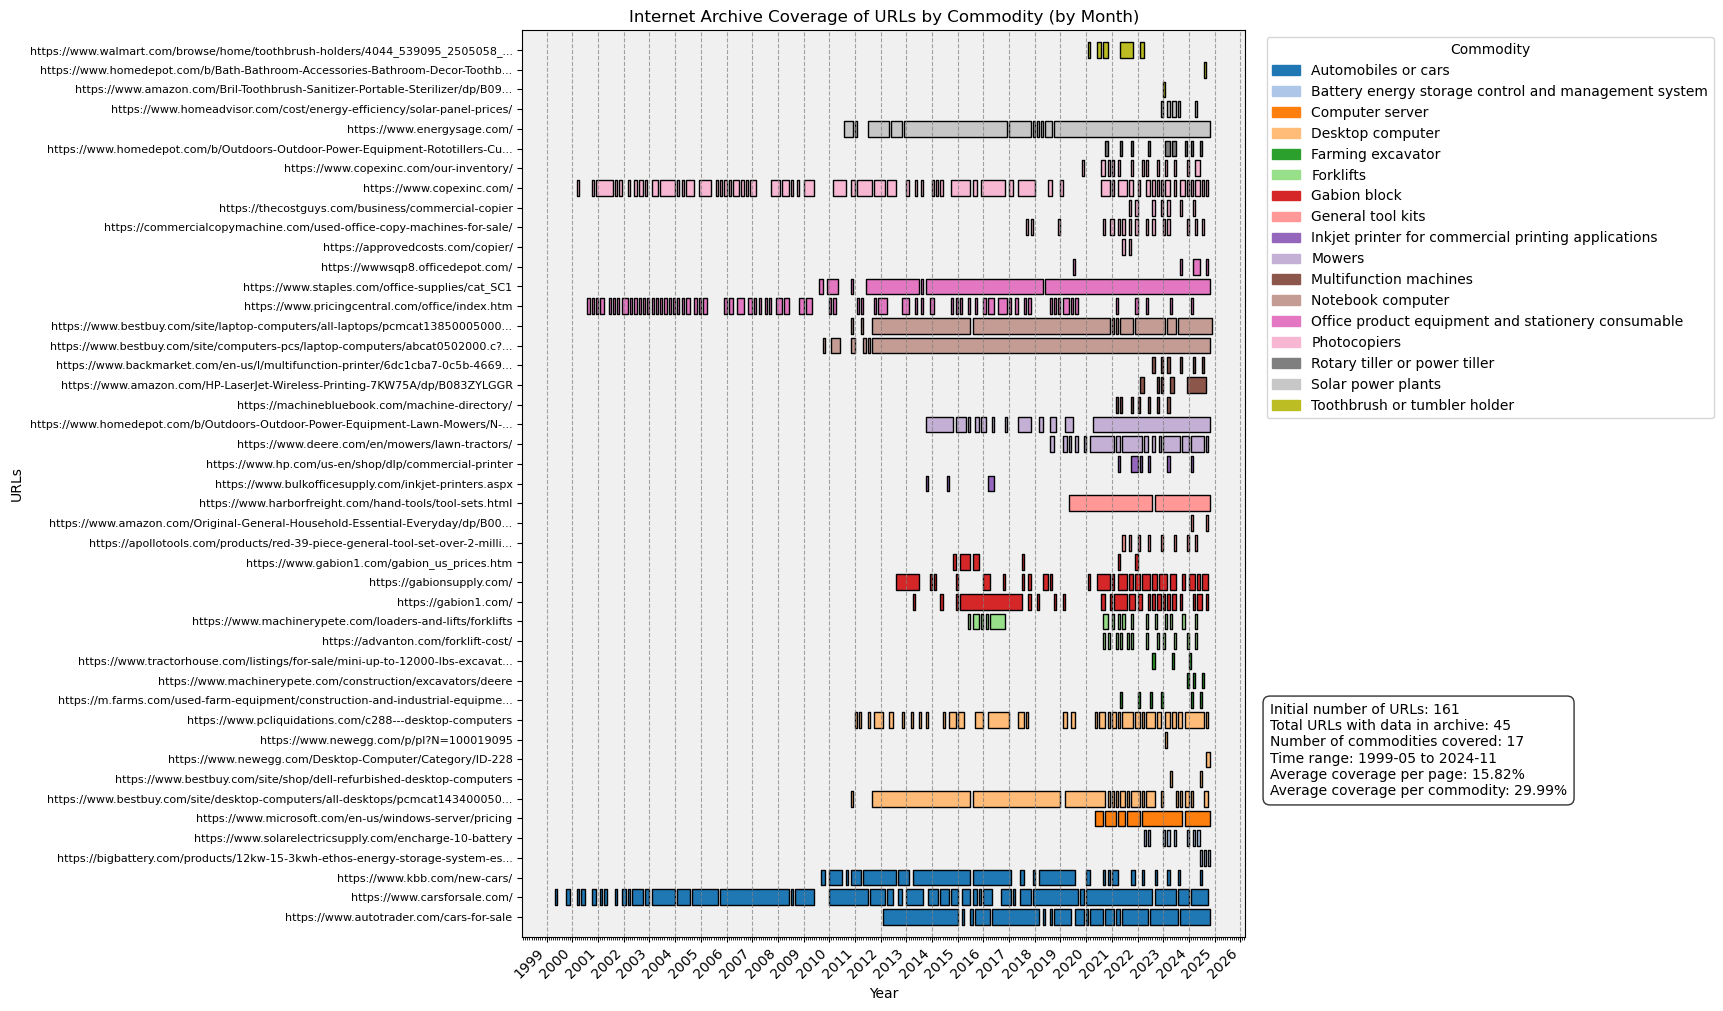

In [13]:
# -----------------------------
# 1. Data Preparation
# -----------------------------

# Filter for 'full_url' type
df_archive_dates_plot = df_urls_m[df_urls_m['url_type'] == 'full_url'].copy()

# Remove rows with invalid or missing timestamps, URLs, or commodities
df_archive_dates_plot = df_archive_dates_plot.dropna(subset=['timestamp', 'url', 'commodity'])

# Convert timestamp to month format (set day to first of the month)
df_archive_dates_plot['timestamp'] = df_archive_dates_plot['timestamp'].dt.to_period('M').dt.to_timestamp()

# Shorten the URL to make it more readable
df_archive_dates_plot['url'] = df_archive_dates_plot['url'].apply(
    lambda x: x[:75] + '...' if len(x) > 75 else x
)

# Drop duplicates to ensure unique (url, commodity, timestamp) combinations
df_archive_dates_plot = df_archive_dates_plot[['url', 'commodity', 'timestamp']].drop_duplicates()

# Create a unique list of URLs and their associated commodities
url_commodity = df_archive_dates_plot[['url', 'commodity']].drop_duplicates()

# Assign a unique index for Y-axis positions
url_commodity = url_commodity.sort_values(['commodity', 'url'])
url_commodity.reset_index(drop=True, inplace=True)
url_commodity['y_index'] = url_commodity.index

# Create mappings from URL to y_index and commodity
url_commodity_combo_to_y = dict(zip(url_commodity[['url', 'commodity']].apply(tuple, axis=1), url_commodity['y_index']))

# Create a colormap for commodities
commodities = url_commodity['commodity'].unique()
colors = plt.cm.tab20.colors  # Use a colormap with enough distinct colors
if len(commodities) > len(colors):
    # Extend the colormap if there are more commodities than colors
    color_cycle = itertools.cycle(colors)
    colors_extended = [next(color_cycle) for _ in range(len(commodities))]
    color_map = dict(zip(commodities, colors_extended))
else:
    color_map = dict(zip(commodities, colors[:len(commodities)]))

# Function to identify consecutive month ranges for a list of timestamps
def get_consecutive_ranges(timestamps):
    """
    Given a sorted list of timestamps (datetime objects),
    return a list of (start, duration_in_days) tuples representing consecutive ranges.
    """
    if not timestamps:
        return []
    
    # Sort the timestamps
    sorted_ts = sorted(timestamps)
    
    ranges = []
    start = sorted_ts[0]
    end = start
    
    for current in sorted_ts[1:]:
        # If current timestamp is exactly one month after the previous, extend the range
        expected_next = (end + pd.DateOffset(months=1)).replace(day=1)
        if current == expected_next:
            end = current
        else:
            # Calculate the duration in days for the broken_barh
            duration = (end + pd.DateOffset(months=1) - start).days
            ranges.append((start, duration))
            start = current
            end = current
    # Append the last range
    duration = (end + pd.DateOffset(months=1) - start).days
    ranges.append((start, duration))
    
    return ranges

# Create a dictionary to hold ranges per URL
url_ranges = {}

# Group the DataFrame by URL and collect ranges
for url_commodity_combo, group in df_archive_dates_plot.groupby(['url', 'commodity']): # Reverse the order for better visualization
    timestamps = group['timestamp'].tolist()
    ranges = get_consecutive_ranges(timestamps)
    url_ranges[url_commodity_combo] = ranges

# -----------------------------
# 2. Plotting
# -----------------------------

# Initialize the plot
num_urls = len(url_commodity)
fig_height = max(10, num_urls * 0.1)  # Adjust the multiplier as needed
fig, ax = plt.subplots(figsize=(15, fig_height))

# Set the background color to light grey
ax.set_facecolor('#f0f0f0')  # Adjust the hex color code for different shades of grey

# Plot each URL's data as broken bars
for url_commodity_combo, ranges in url_ranges.items():
    y = url_commodity_combo_to_y.get(url_commodity_combo)
    commodity = url_commodity_combo[1]
    color = color_map.get(commodity, 'gray')  # Default to gray if commodity not found
    
    for start, duration in ranges:
        # Convert start to matplotlib's date format
        start_num = mdates.date2num(start)
        # Duration in days; for broken_barh, width is in days
        width = duration
        ax.broken_barh(
            [(start_num, width)],
            (y - 0.4, 0.8),  # (y_position, height)
            facecolors=color,
            edgecolor='black'
        )

# -----------------------------
# 3. Customization
# -----------------------------

# Set Y-axis labels to the URLs
ax.set_yticks(url_commodity['y_index'])
ax.set_yticklabels(url_commodity['url'], fontsize=8)  # Adjust fontsize as needed

# Format X-axis to show years and months
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('URLs')
ax.set_title('Internet Archive Coverage of URLs by Commodity (by Month)')

# Improve layout to accommodate labels and legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make space for the legend

# Remove grid lines for a cleaner look
ax.grid(False)

# Rotate X-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Create custom legend
# To avoid duplicate labels in the legend, create a unique list of patches
unique_commodities = commodities
legend_handles = [
    mpatches.Patch(color=color_map[commodity], label=commodity)
    for commodity in unique_commodities
]

ax.legend(handles=legend_handles, title='Commodity', bbox_to_anchor=(1.02, 1), loc='upper left')

# Optional: Adjust Y-axis limits to add some padding
ax.set_ylim(-1, num_urls)

# Optional: Add gridlines at major ticks for X-axis
ax.xaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.7)

# -----------------------------
# 4. Adding the Summary Statistics Box
# -----------------------------

# Compute summary statistics
total_urls = len(url_commodity)
number_of_commodities = len(commodities)
earliest_date = df_archive_dates_plot['timestamp'].min().strftime('%Y-%m')
latest_date = df_archive_dates_plot['timestamp'].max().strftime('%Y-%m')

# Calculate the total number of months in the time range
all_months = pd.period_range(start=df_archive_dates_plot['timestamp'].min(), 
                             end=df_archive_dates_plot['timestamp'].max(), 
                             freq='M')
total_months = len(all_months)

# Calculate coverage per URL
url_month_counts = df_archive_dates_plot.groupby('url')['timestamp'].nunique()
coverage_percent = (url_month_counts / total_months) * 100
average_coverage = coverage_percent.mean()

# Calculate coverage per commodity
commodity_month_counts = df_archive_dates_plot.groupby('commodity')['timestamp'].nunique()
commodity_coverage_percent = (commodity_month_counts / total_months) * 100
average_commodity_coverage = commodity_coverage_percent.mean()

# Define the summary text
summary_text = (
    f"Initial number of URLs: {fullurls_len}\n"
    f"Total URLs with data in archive: {total_urls}\n"
    f"Number of commodities covered: {number_of_commodities}\n"
    f"Time range: {earliest_date} to {latest_date}\n"
    f"Average coverage per page: {average_coverage:.2f}%\n"
    f"Average coverage per commodity: {average_commodity_coverage:.2f}%"
)


# Add the summary box to the figure
fig.text(
    0.85,  # X-coordinate (adjust as needed)
    0.2,   # Y-coordinate (adjust as needed)
    summary_text,
    fontsize=10,
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        edgecolor='black',
        boxstyle='round,pad=0.5'
    )
)

# -----------------------------
# 5. Saving and Displaying the Plot
# -----------------------------

# Save the plot
path = os.path.join(output_dir, 'plots', 'commodity_price_sources', 'internet_archive_coverage_by_commodity_full_url.png')
plt.savefig(path, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()